# Hyperparameters space selection

This notebooks contains data exploratory analysis focused on properties that help to establish hyperparameters for selected clustering methods.

In [1]:
from pathlib import Path
from typing import Optional
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
from pprint import pformat

from utils import load_gemler_data_normed

## Outliers detection

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE

In [ ]:
from utils import NOOP_TRANSFORMER

data_unnonrm, _ = load_gemler_data_normed(NOOP_TRANSFORMER)()

In [ ]:
data_unnonrm.shape

(1545, 7888)

In [ ]:
model = IsolationForest(max_features=0.01)
pred = pd.Series(model.fit_predict(data_unnonrm), index=data_unnonrm.index)
pred.value_counts()

 1    1540
-1       5
dtype: int64

In [86]:
model = LocalOutlierFactor(n_neighbors=2)
pred = pd.Series(model.fit_predict(data_unnonrm), index=data_unnonrm.index)
pred.value_counts()

 1    1488
-1      57
dtype: int64

In [87]:
embedding = pd.DataFrame(
    TSNE(n_components=2, random_state=23, perplexity=30, metric="manhattan").fit_transform(data_unnonrm),
    index=data_unnonrm.index,
    columns=["x", "y"],
)

In [88]:
px.scatter(embedding, x="x", y="y", color=pred.apply(str), height=1e3, width=1e3)

In [81]:
embedding = pd.DataFrame(
    TSNE(n_components=2, random_state=23, perplexity=30, metric="manhattan").fit_transform(data_unnonrm.loc[pred==1]),
    index=data_unnonrm.loc[pred==1].index,
    columns=["x", "y"],
)

In [82]:
px.scatter(embedding, x="x", y="y", height=1e3, width=1e3)

## Loading data

In [2]:
data, _ = load_gemler_data_normed()()

In [3]:
data.shape

(1488, 7888)

## Basic EDA

In [3]:
data.describe()

,1007_s_at,121_at,1405_i_at,1552257_a_at,1552348_at,1552365_at,1552426_a_at,1552610_a_at,1552615_at,1552621_at,...,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,...,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,0.269011,0.126819,0.042835,0.200145,0.012279,0.026633,0.252499,0.328478,0.084021,0.243177,...,0.113337,0.107460,0.112047,0.133158,0.126951,0.143343,0.143757,0.048472,0.042166,0.049293
std,0.111980,0.137108,0.057682,0.127288,0.051416,0.057635,0.098384,0.156523,0.058703,0.123031,...,0.073527,0.074347,0.081121,0.077199,0.074251,0.082473,0.083859,0.054357,0.051540,0.055087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.197591,0.033901,0.010731,0.106592,0.001295,0.007044,0.186504,0.220393,0.050659,0.159641,...,0.067990,0.053577,0.052475,0.083238,0.079961,0.090418,0.088583,0.022919,0.016496,0.021965
50%,0.251379,0.056589,0.024766,0.166822,0.003933,0.011048,0.236867,0.311698,0.072355,0.223906,...,0.102212,0.101408,0.103190,0.121282,0.116237,0.133284,0.133773,0.040632,0.032970,0.040167
75%,0.324192,0.192300,0.052157,0.266173,0.008166,0.021115,0.298149,0.420737,0.100929,0.304841,...,0.142223,0.141080,0.148695,0.163944,0.155445,0.176650,0.178229,0.060950,0.054200,0.062278
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
from ydata_profiling import ProfileReport

In [5]:
data_profile = ProfileReport(
    data,
    minimal=True,
)

In [ ]:
data_profile.to_widgets()

## KMeans, KMedoids
* $k$ parameter search space will be selected here

In [4]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from kneefinder import KneeFinder

KMEANS_K_VALUES = np.arange(2, 41, 1)


def tune_plots_kmeans_k(X: pd.DataFrame) -> Optional[KMeans]:
    """
    Method plotting Sum of Sqared Errors (SSE) and Silhouette scores for selected `k` values range.
    Shape of the plots helps to determine if a range of values is sufficient.
    """
    sse = []
    silhouette_scores = []
    for k in tqdm(KMEANS_K_VALUES, leave=False):
        sse.append(KMeans(n_clusters=k, n_init="auto").fit(X).inertia_)
        labels = KMeans(n_clusters=k, n_init="auto").fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    _, ax = plt.subplots(3, 2, figsize=(10, 15))
    ax = ax.ravel()

    plt.suptitle("KMeans performance")

    ax[0].plot(KMEANS_K_VALUES, sse)
    kf = KneeFinder(KMEANS_K_VALUES, sse)
    knee_x, knee_y = kf.find_knee()
    ax[0].plot([knee_x, knee_x], [min(sse), max(sse)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[0].set_xlabel("k values")
    ax[0].set_ylabel("Sum of Squared Errors")

    ax[1].plot(KMEANS_K_VALUES, silhouette_scores)
    kf = KneeFinder(KMEANS_K_VALUES, silhouette_scores)
    knee_x, knee_y = kf.find_knee()
    ax[1].plot([knee_x, knee_x], [min(silhouette_scores), max(silhouette_scores)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[1].set_xlabel("k values")
    ax[1].set_ylabel("Silhouette score")

    optimal_k = OptimalK(n_jobs=-1, parallel_backend="joblib", n_iter=20, clusterer_kwargs=dict(iter=1, minit="++"))
    _ = optimal_k(data, cluster_array=KMEANS_K_VALUES)

    ax[2].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.gap_value)
    max_gap = optimal_k.gap_df.gap_value.max()
    max_gap_ind = optimal_k.gap_df.gap_value.argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[2].plot(max_gap_n, max_gap, "o")
    ax[2].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[2].set_xlabel("k values")
    ax[2].set_ylabel("Gap statistic")

    ax[3].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "gap*"])
    max_gap = optimal_k.gap_df.loc[:, "gap*"].max()
    max_gap_ind = optimal_k.gap_df.loc[:, "gap*"].argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[3].plot(max_gap_n, max_gap, "o")
    ax[3].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[3].set_xlabel("k values")
    ax[3].set_ylabel("Gap* statistic")

    ax[4].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff"] > 0
    pos_diff = optimal_k.gap_df.loc[:, "diff"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[4].scatter(n, d, marker="o")
        ax[4].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[4].set_xlabel("k values")
    ax[4].set_ylabel("diff = Gap(k) - Gap(k+1) + s(k+1)")

    ax[5].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff*"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff*"] > 0
    pos_diff = optimal_k.gap_df.loc[pos_diff_ind, "diff*"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[5].scatter(n, d, marker="o")
        ax[5].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[5].set_xlabel("k values")
    ax[5].set_ylabel("diff* = Gap*(k) - Gap*(k+1) + s*(k+1)")

    plt.tight_layout()
    plt.show()

    display(optimal_k.gap_df)


  0%|          | 0/39 [00:00<?, ?it/s]

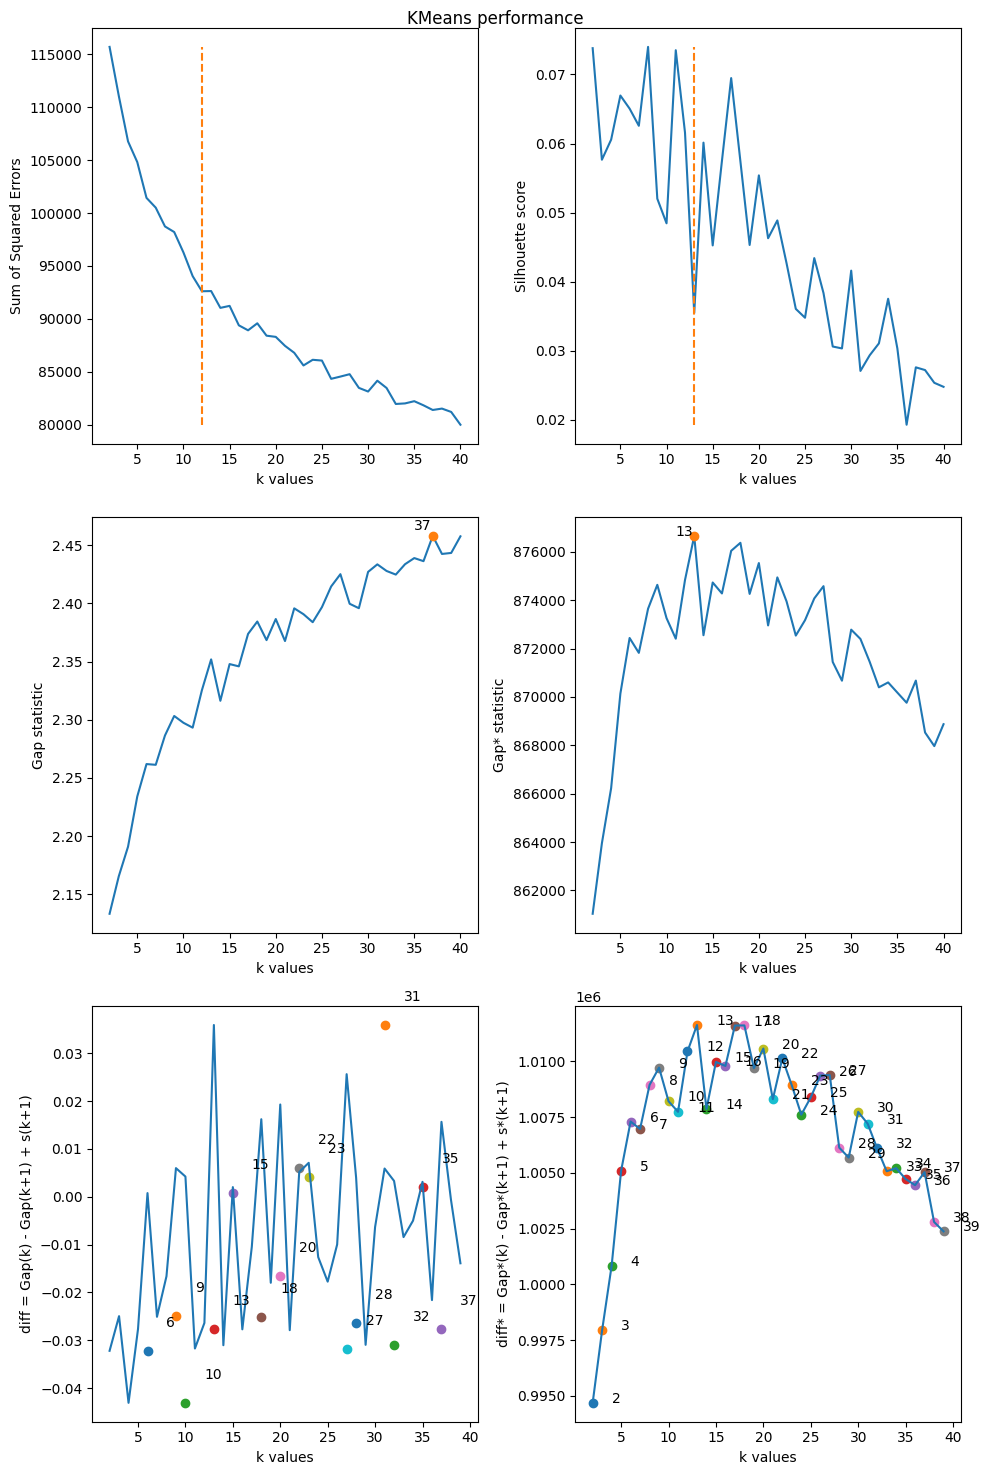

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,2.133269,108.913107,0.000129,861036.839368,9.942397e+05,-0.032192,9.946908e+05
1,3.0,2.165564,87.975952,0.000104,863952.793595,9.976068e+05,-0.024944,9.979588e+05
2,4.0,2.190921,348.780712,0.000413,866227.965562,1.000234e+06,-0.043061,1.000838e+06
3,5.0,2.234085,86.596009,0.000103,870133.302568,1.004743e+06,-0.027630,1.005099e+06
4,6.0,2.261942,191.876172,0.000228,872434.441373,1.007401e+06,0.000770,1.007305e+06
5,7.0,2.261310,115.976796,0.000138,871819.737848,1.006691e+06,-0.025082,1.006973e+06
6,8.0,2.286493,85.451335,0.000101,873643.500127,1.008797e+06,-0.016618,1.008949e+06
7,9.0,2.303278,140.396173,0.000167,874631.065378,1.009937e+06,0.005985,1.009724e+06
8,10.0,2.297426,112.428952,0.000134,873255.154378,1.008348e+06,0.004222,1.008217e+06
9,11.0,2.293231,22.286194,0.000027,872405.003909,1.007367e+06,-0.031713,1.007742e+06


In [6]:
tune_plots_kmeans_k(data)

In [22]:
KMEANS_K_VALUES = np.arange(2, 14, 1)
display(Markdown(f"\n```python\nKMEANS_K_VALUES = {pformat(list(KMEANS_K_VALUES))}\n```"))


```python
KMEANS_K_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
```

## BIRCH
Parameters to evaluate:
* `threshold` - the upper limit of subcluster's radius. 5 values from the range between minimum and $\frac{1}{20}$ of maximum distance between samples will be selected.
* `branching_factor` - maximum number of CF Tree node's sublclusters. This will be simply 5 values sampled from the range `[5, 100)`.
* `n_clusters` - _this will be based on the range selected for KMeans algorithm_

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(data)
min_dist = dist_matrix.min()
max_dist = dist_matrix.max() / 20
display(Markdown(f"For `threshold` 5 values from range `({min_dist}, {max_dist})` will be selected."))

For `threshold` 5 values from range `(0.0, 1.3214501443830946)` will be selected.

In [11]:
BIRCH_THRESHOLD_VALUES = np.linspace(min_dist, max_dist, num=6)[1:]
display(Markdown(f"\n```python\nBIRCH_THRESHOLD_VALUES = {pformat(list(BIRCH_THRESHOLD_VALUES))}\n```"))


```python
BIRCH_THRESHOLD_VALUES = [0.2642900288766189,
 0.5285800577532378,
 0.7928700866298567,
 1.0571601155064756,
 1.3214501443830946]
```

In [12]:
BIRCH_BRANCHING_FACTOR_VALUES = np.linspace(5, 100, num=5, dtype=int)
display(Markdown(f"\n```python\nBIRCH_BRANCHING_FACTOR_VALUES = {pformat(list(BIRCH_BRANCHING_FACTOR_VALUES))}\n```"))


```python
BIRCH_BRANCHING_FACTOR_VALUES = [5, 28, 52, 76, 100]
```

## Affinity propagation
Parameters to evaluate:
* `damping` - extent to which the current value is maintained relative to incoming values (from range `[0.5, 1)`, so 5 values will be sampled from this range)
* `preference` - preference of points, it influences number of exemplars (so also clusters), that will be chosen. Default value is a median of input similarities. Therefore, additionally to median, 10 values from the range selected on this median value will be chosen.

In [11]:
AFFINITY_PROP_DUMPING_VALUES = np.arange(0.5, 1, 0.1)
display(Markdown(f"\n```python\nAFFINITY_PROP_DUMPING_VALUES = {pformat(list(AFFINITY_PROP_DUMPING_VALUES))}\n```"))


```python
AFFINITY_PROP_DUMPING_VALUES = [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999]
```

In [12]:
from sklearn.metrics import pairwise_distances
similarity_matrix = -pairwise_distances(data, metric="sqeuclidean")
display(Markdown(f"Median of similarities (default `preference` value): {np.median(similarity_matrix)}"))

Median of similarities (default `preference` value): -162.16552385229193

In [13]:
AFFINITY_PROP_PREFERENCE_VALUES = np.linspace(2*np.median(similarity_matrix), 0, num=10)
display(Markdown(f"\n```python\nAFFINITY_PROP_PREFERENCE_VALUES = {pformat(list(AFFINITY_PROP_PREFERENCE_VALUES))}\n```"))


```python
AFFINITY_PROP_PREFERENCE_VALUES = [-324.33104770458385,
 -288.29426462629675,
 -252.25748154800965,
 -216.22069846972258,
 -180.18391539143548,
 -144.14713231314838,
 -108.1103492348613,
 -72.0735661565742,
 -36.0367830782871,
 0.0]
```

## DBSCAN
Pameters to evaluate:
* `eps` - the radius of sample's neighborhood
* `min_samples` - minimum number of neighboring samples of a particular sample to consider it a _core point_

Starting poinst for exploration will be determined using approach described in the paper:
```
@inproceedings{rahmah2016determination,
  title={Determination of optimal epsilon (eps) value on dbscan algorithm to clustering data on peatland hotspots in sumatra},
  author={Rahmah, Nadia and Sitanggang, Imas Sukaesih},
  booktitle={IOP conference series: earth and environmental science},
  volume={31},
  number={1},
  pages={012012},
  year={2016},
  organization={IoP Publishing}
}
```

For `min_samples` estimations popular rules of thumb are `num_features+1` or `num_features*2`, however in case of genomic data it is imposible to apply, due to much higher number of dimensions than samples. Therefore a `min_samples` will be gridsearched from range `[3, num_samples/40)`. Five values will be uniformly selected from this range and for each value a proper epsilon value will be selected.

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


MIN_SAMPLES_VALUES = np.linspace(3, data.shape[0]/40, num=5, dtype=int)

def tune_dbscan(X: pd.DataFrame, min_samples: int, ax: Optional[plt.Axes]=None) -> Optional[DBSCAN]:
    # tune epsilon with estimation based on NN
    k = min_samples - 1
    nns = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nns.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    ax = ax if ax is not None else plt.gca()
    ax.plot(distances)
    kf = KneeFinder(range(0, len(distances)), distances)
    knee_x, knee_y = kf.find_knee()
    ax.plot([0, len(distances)], [knee_y, knee_y], '--', label=f"Knee at {knee_x, knee_y}")
    ax.set_title(f"Distance Curve (of KNN) for {min_samples}")
    ax.set_ylabel("Distance threshold (epsilon)")
    ax.legend()
    return knee_y # found eps value

In [9]:
display(Markdown(f"\n```python\nMIN_SAMPLES_VALUES = {pformat(list(MIN_SAMPLES_VALUES))}\n```"))


```python
MIN_SAMPLES_VALUES = [3, 11, 20, 28, 37]
```

/var/folders/_h/6ffwq3jn4g94mt887zqcgpth0000gn/T/ipykernel_2036/428225744.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


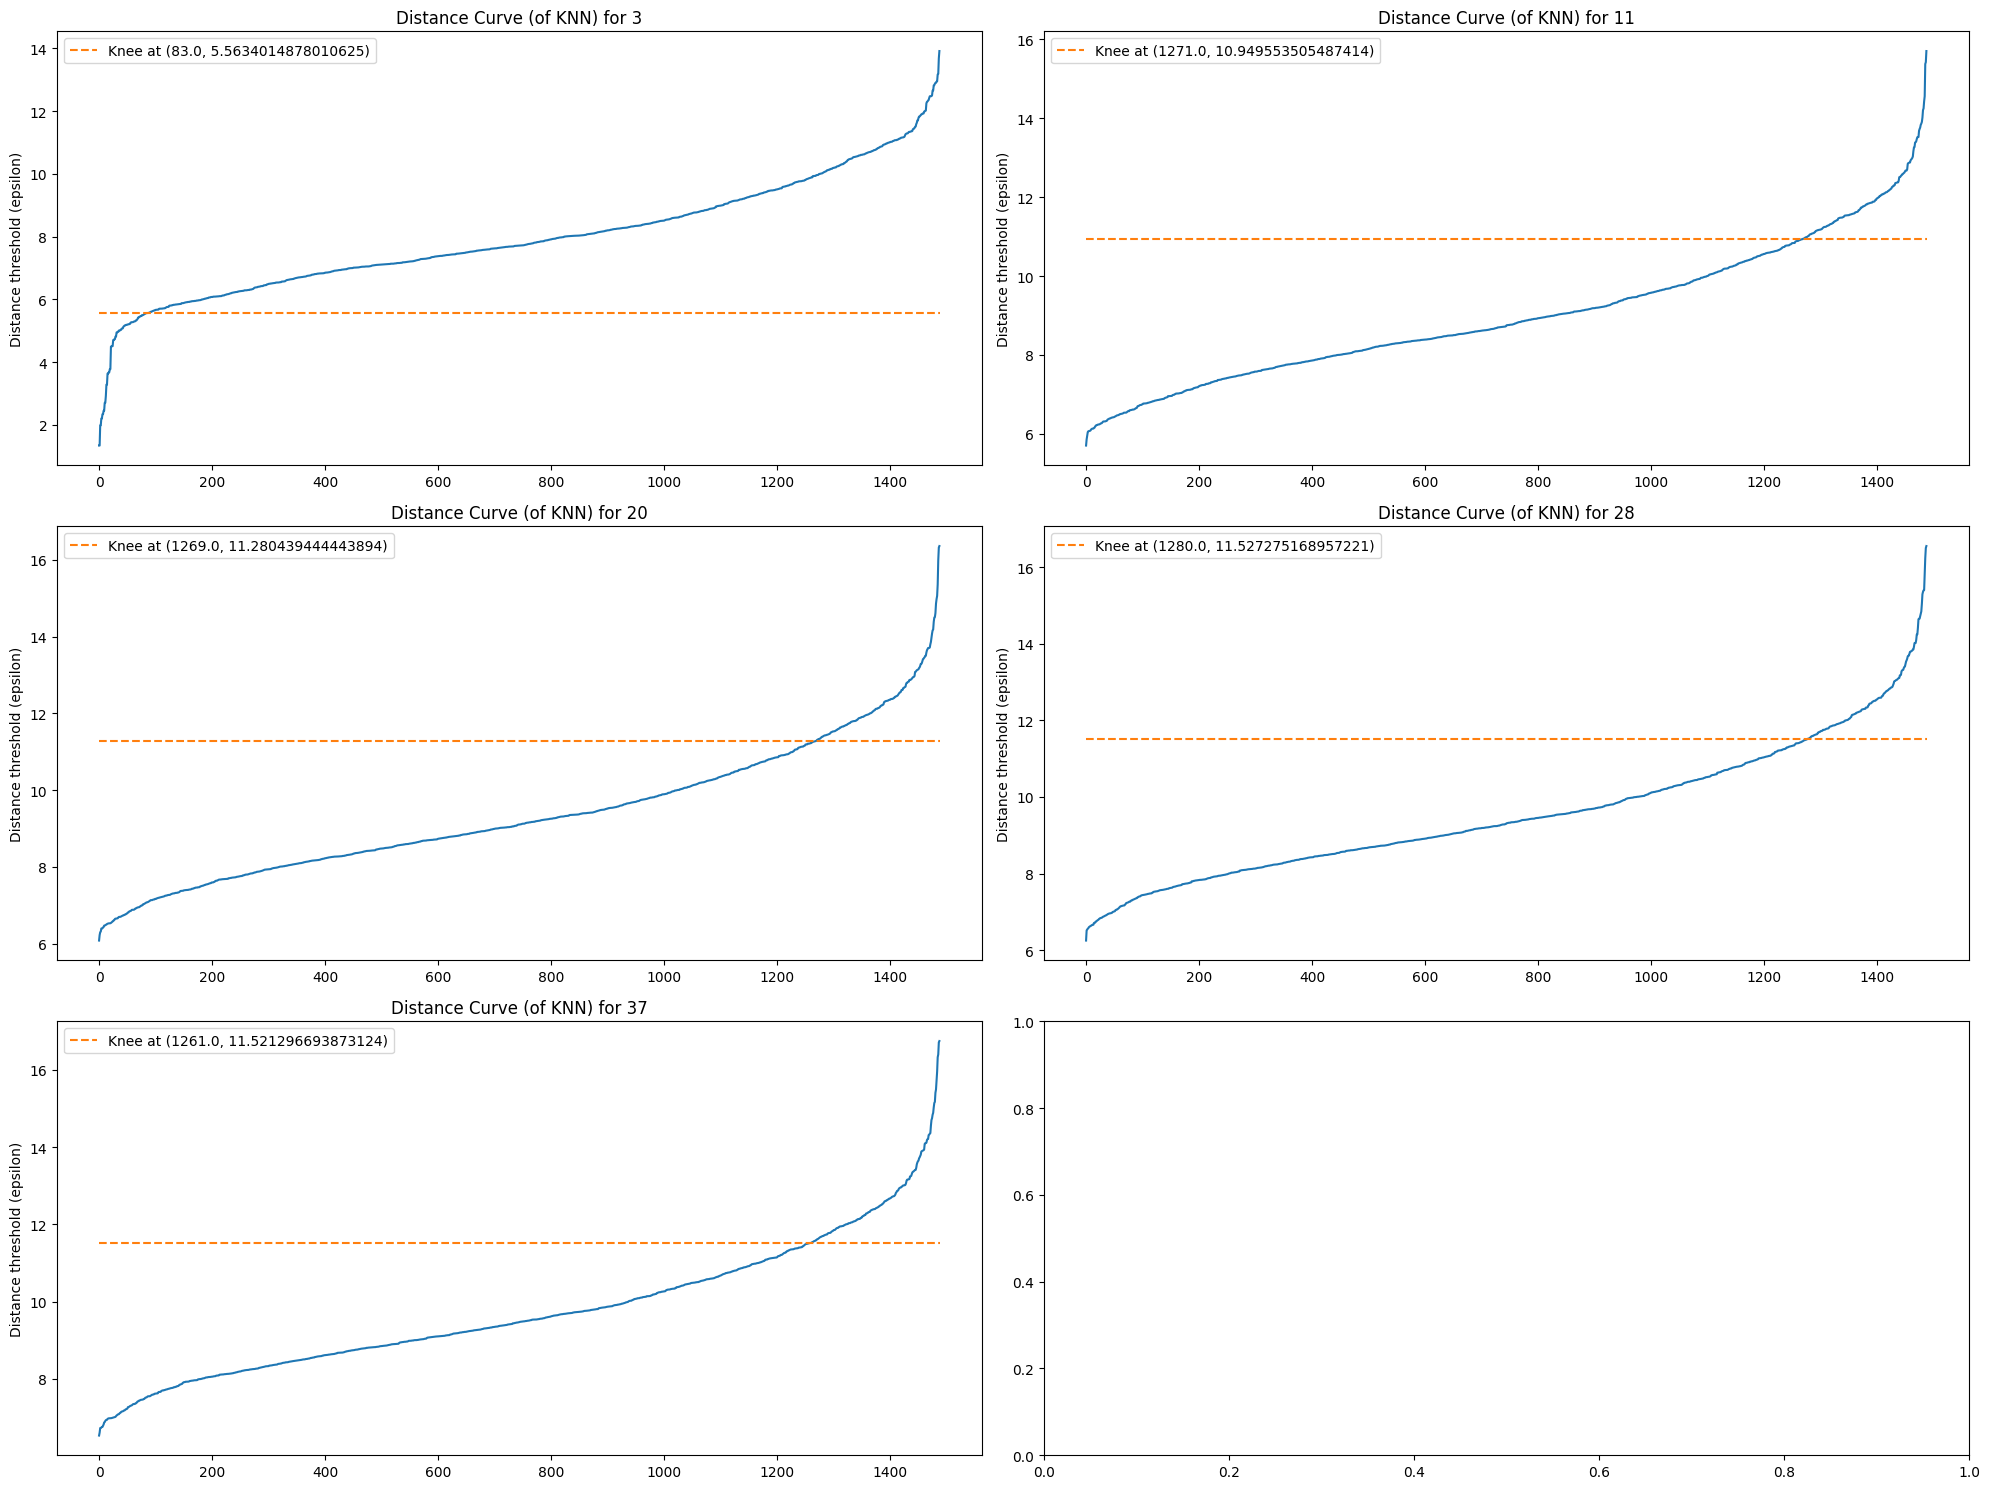

In [8]:
found_eps_values = []
ncols = 2
nrows = int(np.ceil(len(MIN_SAMPLES_VALUES) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))
axs = np.ravel(axs)
for min_samples, ax in zip(MIN_SAMPLES_VALUES, axs):
    found_eps_values.append(tune_dbscan(data, min_samples, ax))
fig.tight_layout()
fig.show()

In [9]:
EPS_VALUES = found_eps_values
display(Markdown(f"\n```python\nEPS_VALUES = {pformat(list(EPS_VALUES))}\n```"))


```python
EPS_VALUES = [5.5634014878010625,
 10.949553505487414,
 11.280439444443894,
 11.527275168957221,
 11.521296693873124]
```

## OPTICS
This method is used as an improvement of DBSCAN (`cluster_method="dbscan"`), therefore only `min_samples` parameter needs to be provided and it can be copied from the values estimated for DBSCAN.

## Gaussian Mixtures
Parameters to evaluate:
* `n_components` - number of mixture components (It will be copied from $k$ value established for KMeans)

As GM can not handle too many dimensions nicely. PCA will be applied to reduce number of input features for this algorithm. TO evaluate number of components for PCA decomposition, an analysis of variation explained will be performed.

In [18]:
from sklearn.decomposition import PCA

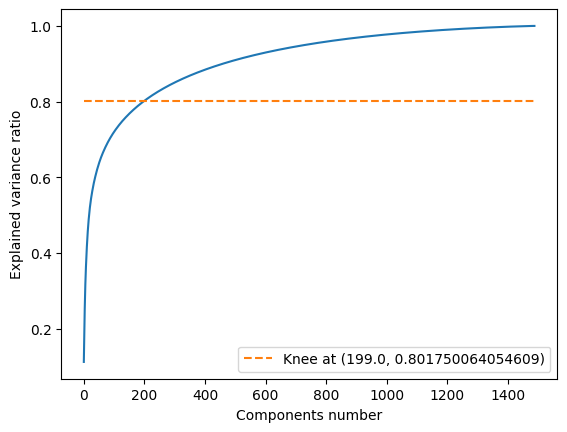

In [19]:
pca = PCA().fit(data)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.plot(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues)
kf = KneeFinder(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues)
knee_x, knee_y = kf.find_knee()
plt.plot([0, len(cum_sum_eigenvalues)], [knee_y, knee_y], '--', label=f"Knee at {knee_x, knee_y}")
plt.ylabel('Explained variance ratio')
plt.xlabel('Components number')
plt.legend()
plt.show()

In [20]:
display(Markdown(f"Knee found for `{int(knee_x)}` components explaining `{knee_y*100:.2f}%` of variance."))

Knee found for `199` components explaining `80.18%` of variance.

## SOM
Paramters to evaluate:
* `m` / `n` - number of neurons in the row / col of som grid (2D map is used). It will be copied from KMeans $k$ value, but with additional `1` value, so there could be a map which is 1D as well. So the number of clusters matches previously selected `k` space, there will be rule `m * n <= max(K_VALUES)`.
* `epochs` - number of training epochs. Values of `[10, 50, 100, 200, 300]` will be provided.

In [21]:
from itertools import product

display(
    Markdown(
        f"\n```python\nN_COLS_N_ROWS_PAIRS = {pformat([(k1, k2) for k1, k2 in product([1] + list(KMEANS_K_VALUES), list(KMEANS_K_VALUES)) if k1 * k2 <= max(KMEANS_K_VALUES)])}\n```"
    )
)



```python
N_COLS_N_ROWS_PAIRS = [(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 2),
 (4, 3),
 (5, 2),
 (6, 2),
 (7, 2)]
```

In [10]:
display(
    Markdown(
        f"\n```python\SOM_EPOCHS = [10, 50, 100, 200, 300]\n```"
    )
)


```python\SOM_EPOCHS = [10, 50, 100, 200, 300]
```

## Sepctral Clustering
Parameters to evaluate:
* `n_clusters` - number of clusters (It will be copied from $k$ value established for KMeans).
* `affinity` - method of construction of afinity matrix. Two available options will be checked: `["nearest_neighbors", "rbf"]`. For `"nearest_neighbors"` `n_neighbors` will be copied from the `MIN_SAMPLES_VALUES` selected for DBSCAN algorithm.
* `assign_labels` - how final cluter labels are assigned in the embedding space. All available options will be checked: `["kmeans", "discretize", "cluster_qr"]`.